# Lecture 16:  Iterative methods for large scale eigenvalue problems

## Previous lecture

- Matrix functions: matrix exponential, methods to compute matrix exponential, other matrix functions
- Krylov methods for computing action of matrix functions
- Matrix equations (Lyapunov equations, Sylvester equation)

## Partial eigenvalue problem

- Recall that to find eigenvalues of matrix of size $N\times N$ one can use, e.g. the QR algorithm.

- However, in some applications matrix is so large, that we even can not store it exactly.

- Typically such matrices are given as a **black-box** that is able only to multiply matrix by vector (sometimes even without access to matrix elements). This is what we assume today.

- In this case the best we can do is to solve partial eigenvalue problem, e.g.

    - Find $k\ll N$ smallest or largest eigenvalues (and eigenvectors if needed)
    - Find $k\ll N$ eigenvalues closest to a given number $\sigma$

- For simplicity we will consider the case when matrix is normal and thus has orthonormal basis of eigenvectors. 



## Power method and related methods

### Power method

Recall that the simplest method to find the largest eigenvalue is the **power method**

$$
    x_{i+1} = \frac{Ax_{i}}{\|Ax_{i}\|}
$$

The convergence is linear with rate $q = \left|\frac{\lambda_1}{\lambda_2}\right|$.

### Inverse iteration

To find the smallest eigenvalue one may run power method for $A^{-1}$:

$$x_{i+1} = \frac{A^{-1}x_{i}}{\|A^{-1}x_{i}\|}.$$

To accelerate convergence <font color='red'>shift-and-invert</font> strategy can be used:

$$x_{i+1} = \frac{(A-\sigma I)^{-1}x_{i}}{\|(A-\sigma I)^{-1}x_{i}\|},$$

where $\sigma$ should be close to the eigenvalue we want to find.

### Rayleigh quotient (RQ) iteration

In order to get superlinear convergence one may use adaptive shifts:

$$x_{i+1} = \frac{(A-R(x_i) I)^{-1}x_{i}}{\|(A-R(x_i) I)^{-1}x_{i}\|},$$

where $R(x_k) = \frac{(x_i, Ax_i)}{(x_i, x_i)}$ is Rayleigh quotient. 

The method converges **cubically for Hermitian matrices** and quadratically for non-Hermitian case.

### Inexact inverse iteration framework

- Matrices $(A- \sigma I)$ as well as $(A-R(x_i) I)$ are ill-conditioned if $\sigma$ or $R(x_i)$ are close to eigenvalues.

- Thus, if you are not given e.g. LU factorization of such matrix you might face a problem.

- In practice you can solve systems only with some accuracy. Recall also that condition number is an upper bound and is overestimated for cosistent rhs. So, even in RQ iteration  letting
the shift tend to the eigenvalue [does not harm](http://www.sciencedirect.com/science/article/pii/S0024379505005756) significantly
the performance of the iterative methods.

- If accuracy of solution of systems increases from iteration to iteration, superlinear convergence for RQ iteration can still be present, see [Theorem 2.1](http://www.sciencedirect.com/science/article/pii/S0024379505005756).
Otherwise, you will get linear convergence.

### Block power method

The block power method (also known as subspace iteration method or simultaneous vector iteration) is a natural generalization of the power method for several largest eigenvalues.<br>
It looks as:

1. $Y_0$ is $N\times k$ matrix of rank $k$, $Y_0 = X_0 R_0$ (QR-decomposition)
2. $Y_i = AX_{i-1}$ 
3. $Y_i = X_i R_i$ (QR-decomposition)

QR-decomposition plays role of normalization in the standard power method. 

Moreover, orthogonalization prevents the columns of the $X_i$ from converging all to the eigenvector corresponding to the largest modulus eigenvalue.

### Accelerating convergence of the block power method

* For Hermitian matrices convergence of the $j$-column is **linear** as for the power method with $q=\frac{|\lambda_{j}|}{|\lambda_{j+1}|}$. 


* Hence, applying the block power method to the matrix $(A-\sigma I)^{-1}$ will accelerate convergence (<font color='red'>shift-and-invert</font> strategy).


* You can also accelerate the convergence by applying the **Rayleigh-Ritz procedure** discussed below.

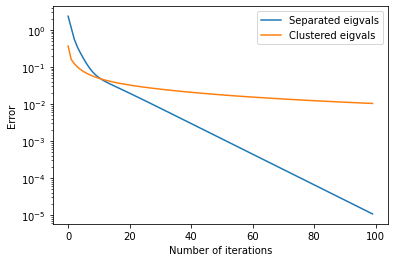

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline

n = 100
k = 10
A = np.diag(1./(1. + np.arange(n))) # diagonal matrix with well-separated maximum eigenvalues
A_clustered = np.diag(1 - 1./(1. + np.arange(n))) # diagonal matrix with clustered maximum eigenvalues

def subspace_iter(A, Y0, num_iter=100):
    Y0, _ = np.linalg.qr(Y0)
    Y = Y0.copy()
    Y_old = Y0.copy()
    err = []
    for i in range(num_iter):
        X = A.dot(Y)
        Y, _ = np.linalg.qr(X)
        err.append(np.linalg.norm(Y_old - Y.dot(Y.T.dot(Y_old))))
        Y_old = Y.copy()
    return Y, err

Y0 = np.random.random((n, k))
Y, err = subspace_iter(A, Y0, num_iter=100)
Y, err_clustered = subspace_iter(A_clustered, Y0, num_iter=100) #np.diag((diagonal - sigma)**(-1))
plt.semilogy(err, label='Separated eigvals')
plt.semilogy(err_clustered, label='Clustered eigvals')
plt.xlabel('Number of iterations')
plt.ylabel('Error')
plt.legend(loc='best')

Before we go to advanced methods let us discuss the important concept of **Ritz approximation**.

## Ritz approximation

Given subspace spanned by columns of unitary matrix $Q_k$ of size $N\times k$ we consider the projected matrix $Q_k^* A Q_k$.

Let $\Theta_k=\mathrm{diag}(\theta_1,\dots,\theta_k)$ and $S_k=\begin{bmatrix}s_1 & \dots & s_k \end{bmatrix}$ be matrices of eigenvalues and eigenvectors of $(Q_k^* A Q_k)$: 

$$(Q_k^* A Q_k)S_k = S_k \Theta_k$$

then $\{\theta_i\}$ are called **Ritz values** and $y_i = Q_k s_i$ - **Ritz vectors**.

### Properties of the Ritz approximation

- Note that they are not eigenpairs of the initial matrix $AY_k\not= Y_k \Theta_k$, but the following equality holds:

    $$Q_k^* (AY_k - Y_k \Theta_k) = Q_k^* (AQ_k S_k - Q_k S_k \Theta_k) = 0,$$

   so the residual for the Ritz approximation is **orthogonal** to the subspace spanned by columns of $Q_k$.

- $\lambda_\min(A) \leq \theta_\min \leq \theta_\max \leq \lambda_\max(A)$. Indeed, using Rayleigh quotient:

    $$\theta_\min = \lambda_\min (Q_k^* A Q_k) = \min_{x\not=0} \frac{x^* (Q_k^* A Q_k) x}{x^* x} = \min_{y\not=0:y=Q_k x} \frac{y^*  A y}{y^* y}\geq \min_{y\not= 0} \frac{y^*  A y}{y^* y} = \lambda_\min(A).$$

    Obviously, $\lambda_\min (Q_k^* A Q_k) = \lambda_\min(A)$ if $k=N$, but we want to construct a basis $k\ll N$ such that $\lambda_\min (Q_k^* A Q_k) \approx \lambda_\min(A)$.

    Similarly, $\theta_\max \leq \lambda_\max(A)$.

### <font color='red'>Rayleigh-Ritz method</font>

Thus, if a subspace $V$ approximates first $k$ eigenvectors, then one can use the **Rayleigh-Ritz method**:

1. Find orthonormal basis $Q_k$ in $V$ (e.g. by using QR decomposition)
2. Calculate $Q_k^*AQ_k$
3. Compute Ritz values and vectors
4. Note that alternatevly one could use $V$ with no orthogonalization, but then generalized eigenvalue problem $(V^*AV)s_i = \theta_i (V^*V)s_i$ has to be solved.

The question is how to find a good subspace $V$.

## Lanczos and Arnoldi methods

The good choice for $V$ is the Krylov subspace.

Recall that in the power method we used only one Krylov vector 

$$x_k = \frac{A^k x_0}{\|A^k x_0\|}.$$

In this case $\theta_k = \frac{x_k^* A x_k}{x_k^* x_k}$ is nothing but a Ritz value. Natural idea is to use a bigger Krylov subspace.

As a result we can find more eigenvalues (power method only gives $\lambda_\max$). Moreover,convergence of the eigenvalue corresponding to $\lambda_\max$ will be faster.

For Hermitian matrices from the Arnoldi relation we have

$$
Q_k^*AQ_k = T_k,
$$

where $Q_k$ is orthogonal basis in the Krylov subspace generated by the Lanczos procedure and $T_k$ is triangular matrix.

According to the Rayleigh-Ritz method we expect that eigenvalues of $T_k$ approximate eigenvalues of $A$. This method is called the **Lanczos method**. For nonsymmetric matrices it is called the **Arnoldi method** and instead of tridiagonal $T_k$ we would get upper=Hessenberg matrix.

Let us show that  $\theta_\max \approx\lambda_\max$.

### Why is $\theta_\max \approx \lambda_\max$?

Let us denote $\theta_1 \equiv \theta_\max$ and $\lambda_1 \equiv \lambda_\max$. Then

$$
    \theta_1 = \max_{y\in \mathcal{K}_i, y\not=0}\frac{(y,Ay)}{(y,y)} = \max_{p_{i-1}} \frac{(p_{i-1}(A)x_0, A p_{i-1}(A)x_0)}{(p_{i-1}(A)x_0, p_{i-1}(A)x_0)},
$$

where $p_{i-1}$ is a polynomial of degree not greater than $i-1$ such that $p_{i-1}(A)x_0\not=0$.

Expand $x_0 = \sum_{j=1}^N c_j v_j$, where $v_j$ are eigenvectors of $A$ (form orthonormal basis).

Since $\theta_1 \leq \lambda_1$ we get
$$
    \lambda_1 - \theta_1 \leq \lambda_1 - \frac{(p_{i-1}(A)x_0, A p_{i-1}(A)x_0)}{(p_{i-1}(A)x_0, p_{i-1}(A)x_0)}
$$
for any polynomial $p_{i-1}$. Hence
$$
\lambda_1 - \theta_1 \leq \lambda_1 - \frac{\sum_{k=1}^N \lambda_k |p_{i-1}(\lambda_k)|^2 |c_k|^2}{\sum_{k=1}^N |p_{i-1}(\lambda_k)|^2 |c_k|^2} =
$$
$$
= \frac{\sum_{k=2}^N (\lambda_1 - \lambda_k) |p_{i-1}(\lambda_k)|^2 |c_k|^2}{|p_{i-1}(\lambda_1)|^2 |c_1|^2 + \sum_{k=2}^N |p_{i-1}(\lambda_k)|^2 |c_k|^2} \leq 
(\lambda_1 - \lambda_n) \frac{\max_{2\leq k \leq N}|p_{i-1}(\lambda_k)|^2}{|p_{i-1}(\lambda_1)|^2 }\gamma, \quad \gamma = \frac{\sum_{k=2}^N|c_k|^2}{|c_1|^2}
$$

Since the inequality holds for any polynomial $p_{i-1}$ we will choose a polynomial: 

$$|p_{i-1}(\lambda_1)| \gg \max_{2\leq k \leq N}|p_{i-1}(\lambda_k)|.$$

This holds, e.g. for the Chebyshev polynomial on $[\lambda_n,\lambda_2]$. Thus, $\theta_1 \approx \lambda_1$ or more precisely (Paige-Kaniel error bound, check it!):
$$
    \lambda_1 - \theta_1 \leq \frac{\lambda_1 - \lambda_n}{T_{i-1}^2(1 + 2\mu)}\gamma, \quad \mu = \frac{\lambda_1 - \lambda_2}{\lambda_2 - \lambda_n},
$$
where $T_{i-1}$ is a Chebyshev polynomial.

### Demo: approximating largest eigenvalue with Lanczos

In [3]:
import scipy as sp
import scipy.sparse
from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse.linalg
import copy
n = 40
ex = np.ones(n)
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr')
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)

def lanczos(A, m):
    n = A.shape[0]
    v = np.random.random((n, 1))
    v = v / np.linalg.norm(v)
    v_old = np.zeros((n, 1))
    beta = np.zeros(m)
    alpha = np.zeros(m)
    for j in range(m-1):
        w = A.dot(v)
        alpha[j] = w.T.dot(v)
        w = w - alpha[j] * v - beta[j] * v_old
        beta[j+1] = np.linalg.norm(w)
        v_old = v.copy()
        v = w / beta[j+1]
    w = A.dot(v)
    alpha[m-1] = w.T.dot(v)
    A = np.diag(beta[1:], k=-1) + np.diag(beta[1:], k=1) + np.diag(alpha[:], k=0)
    l, _ = np.linalg.eigh(A)
    return l

# Approximation of the largest eigenvalue for different k
l_large_exact = sp.sparse.linalg.eigsh(A, k=99, which='LM')[0][0]
print('k=10, err = {}'.format(np.abs(l_large_exact - lanczos(A, 10)[0])))
print('k=20, err = {}'.format(np.abs(l_large_exact - lanczos(A, 20)[0])))
print('k=100, err = {}'.format(np.abs(l_large_exact - lanczos(A, 100)[0])))

k=10, err = 0.1681667143962713
k=20, err = 0.022651261043122872
k=100, err = 6.365130644780947e-10


### Practical issues and stability

- The Lanczos vectors may loose orthogonality during the process due to floating-point errors, thus all practical implementations of it use **restarts**.

- A very good introduction to the topic is given in the book of **Golub and Van-Loan (Matrix Computations)**.

### More problems with the Lanczos method

- Applying Lanczos directly to $A$ may result into a very slow convergence if $\lambda_i\approx \lambda_{i+1}$ <br> (typically holds for smallest eigenvalues that are not well-separated)


- To accelerate the convergence one may apply Lanczos to $(A-\sigma I)^{-1}$, but in this case systems have to be solved **very accurately**. <br>
Otherwise the Arnoldi relation does not hold anymore.

An alternative to this approach are the so-called preconditioned iterative methods that include:
1. PINVIT (Preconditioned Inverse Iteration)
2. LOBCPG (Locally optimal block preconditioned CG)
3. Jacobi-Davidson method

## PINVIT (preconditioned inverse iteration)

### Derivation

Consider Rayleigh quotient $R(x) = \frac{(x,Ax)}{(x,x)}$. Then
$$
\nabla R(x) = \frac{2}{(x,x)} (Ax - R(x) x),
$$

so the simplest gradient descent method with a preconditioner $B$ reads

$$
    x_{i+1} = x_{i} - \tau_i B^{-1} (Ax_i - R(x_i) x_i),
$$

$$
    x_{i+1} = \frac{x_{i+1}}{\|x_{i+1}\|}.
$$

Typically $B\approx (A-\sigma I)$, where $\sigma$ is called shift.

The closer $\sigma$ to the required eigenvalue is, the faster the convergence.

- Parameter $\tau_k$ is chosen to minimize the $R(x_{i+1})$ over $\tau_k$ (steepest descent method).

- One can think of this minimization procedure as minimization in basis $V = [x_i, r_i]$, where $r_{i}=B^{-1} (Ax_i - R(x_i) x_i)$.

- This results into the generalized eigenvalue problem $(V^*AV)\begin{bmatrix}1 \\ -\tau_i \end{bmatrix} = \theta (V^*V) \begin{bmatrix}1 \\ -\tau_i \end{bmatrix}$ (Rayleigh-Ritz procedure with no orthogonalization of $V$). Here $\theta$ is the closest to the required eigenvalue.

### Convergence theory

**Theorem** ([Knyazev and Neymeyr](http://www.sciencedirect.com/science/article/pii/S002437950100461X)) 

Let 
- $R(x_{i})\in [\lambda_j,\lambda_{j+1}]$
- $R(x_{i+1})\in [R(x_{i}),\lambda_{j+1}]$ (case $R(x_{i+1})\in [\lambda_{j}, R(x_{i})]$ is similar)
- $\|I - B^{-1} A\|_A \leq \gamma < 1$

then

$$
\left|\frac{R(x_{i+1}) - \lambda_j}{R(x_{i+1}) - \lambda_{j+1}}\right| < \left[ 1 - (1-\gamma)\left(1 - \frac{\lambda_j}{\lambda_{j+1}}\right) \right]^2 \cdot \left|\frac{R(x_{i}) - \lambda_j}{R(x_{i}) - \lambda_{j+1}}\right|
$$

### Block case

To find, e.g. $k$ eigenvalues one can do a one step of PINVIT for each vector:


$$
    x^{(j)}_{i+1} = x^{(j)}_{i} - \tau^{(j)}_i B^{-1} (Ax^{(j)}_i - R(x^{(j)}_i) x^{(j)}_i), \quad j=1,\dots,k
$$

$$
    x^{(j)}_{i+1} = \frac{x^{(j)}_{i+1}}{\|x^{(j)}_{i+1}\|}.
$$

And then orthogonalize them using the QR-decomposition. However, it is better to use the Rayleigh-Ritz procedure:

- Set $X^{i}_k = [x^{(1)}_{i},\dots, x^{(k)}_{i}]$ and $R^{i}_k = [B^{-1}r^{(1)}_{i},\dots, B^{-1}r^{(k)}_{i}]$, where $r^{(j)}_{i} = Ax^{(j)}_i - R(x^{(j)}_i) x^{(j)}_i$


- Set $V = [X^{i}_k, R^{i}_k]$, use Rayleigh-Ritz procedure for $V$ to find new $X^{i+1}_k$.

## LOBPCG (Locally Optimal Block Preconditioned CG)

### Locally optimal PCG (not "Block" so far :))
LOPCG method

$$
    x_{i+1} = x_{i} - \alpha_i B^{-1} (Ax_i - R(x_i) x_i) + \beta_i x_{i-1} ,
$$

$$
    x_{i+1} = \frac{x_{i+1}}{\|x_{i+1}\|}.
$$


is a superior to PINVIT method as it adds to basis not only $x_i$ and $r_i$, but also $x_{i-1}$.

However, this interpretation leads to an unstable algorithm as $x_{i}$ is becoming colinear to $x_{i-1}$ as the procedure converges.

### LOPCG (stable version)

Knyazev suggested an equivalent stable version, which introduces new vectors $p_i$ (conjugate gradients)

$$
p_{i+1} = r_{i} + \beta_i p_{i},
$$

$$
x_{i+1} = x_{i} + \alpha_i p_{i+1}.
$$

One can check that $\mathcal{L}(x_{i},x_{i-1},r_{i})=\mathcal{L}(x_{i},p_{i},r_{i})$.

The stable version explains name of the method:

In standard CG method we would minimze Rayleigh quotient $R$ in the conjugate gradient direction $p_{i+1}$: 

$$\alpha_i = \arg\min_{\alpha_i} R(x_i + \alpha_i p_{i+1}).$$

In the locally-optimal CG we minimize over two parameters:  

$$\alpha_i, \beta_i = \arg\min_{\alpha_i,\beta_i} R\left(x_i + \alpha_i p_{i+1}\right) = \arg\min_{\alpha_i,\beta_i} R\left(x_i + \alpha_i (r_{i} + \beta_i p_{i})\right)$$

and we locally obtain more optimal solution. That is why the method is called **locally optimal**.

As for PINVIT coefficients $\alpha_i,\beta_i$ can be found by the Rayleigh-Ritz procedure.

### Locally optimal <font color='red'> block </font> PCG

In the block version similarly to PINVIT on each iteration we are given basis $V=[X^{(i)}_k,B^{-1}R^{(i)}_k, P^{(i)}_k]$ and use Rayleigh-Ritz procedure.

The overall algorithm:

1. Find $\tilde A = V^* A V$
2. Find $\tilde M = V^*V$
3. Solve generalized eigenvalue problem $\tilde A S_k = \tilde M S_k \Theta_k$
4. $P^{(i+1)}_{k} = [B^{-1}R^{(i)}_k, P^{(i)}_k]S_k[:,k:]$
5. $X^{(i+1)}_{k} = X^{(i)}_k S_k[:,:k] + P^{(i+1)}_{k}$ (equivalent to $X^{(i+1)}_{k} = VS_k$)
6. Calculate new $B^{-1}R^{(i+1)}_k$
7. Set $V=[X^{(i+1)}_k,B^{-1}R^{(i+1)}_k, P^{(i+1)}_k]$, goto 1.

**Deflation technique** which stops iterating converged eigestates can also be applied here.

The method also converges linearly, but faster than PINVIT.

### LOBPCG summary

- Locally optimal preconditioned solver

- Linear convergence

- Preconditioner $(A-\sigma I)$ is not always good for eigenvalue problems

The next method (Jacobi-Davidson) has smart preconditioning and superlinear convergence (if systems are solved accurately)!

## Jacobi-Davidson (JD) method

Jacobi-Davidson method is a very popular technique for solving eigvalue problems (not only symmetric!).

It consits of two **key ingredients**:

- Given a preconditioner for $A-R(x_j) I$ it automatically constructs a good preconditioner for the eigevalue problem:
$$
    B = (I - x_j x^*_j) (A - R(x_j) I) (I - x_j x^*_j),
$$
where $x_j$ - is approximation to the eigenvector on the $j$-th iteration.<br> **Note** that sometimes approximation to $(A-R(x_j) I)^{-1}$ is not a good preconditioner.


- It additionally adds to a subspace $V$ solutions from previous iterations (**subspace acceleration**)

### JD derivation

- Jacobi-Davidson method has a nice manifold optimization interpretation. 
- It is a **Riemannian Newton** method on a sphere and $P = I - x_j x^*_j$ is a projection on a tanget space of a sphere at $x_j$.

But we will derive it similarly to the original paper.

### Jacobi correction equation

Jacobi not only presents the way to solve the eigenvalue problem by Jacobi rotations, but also proposed an iterative procedure. Let $x_j$ be the current approximation, and $t$ the correction:

$$A(x_j + t) = \lambda (x_j + t),$$

and we look for the correction $t \perp x_j$ (new orthogonal vector).

Then, the parallel part has the form

$$x_j x^*_j A (x_j + t) = \lambda x_j,$$

which simplifies to 

$$R(x_j) + x^* _j A t = \lambda.$$

The orthogonal component is 

$$( I - x_j x^*_j) A (x_j + t) = (I - x_j x^*_j) \lambda (x_j + t),$$

which is equivalent to 

$$
  (I - x_j x^*_j) (A - \lambda I) t = (I - x_j x^*_j) (- A x_j + \lambda x_j) = - (I - x_j x^*_j) A x_j = - (A - R(x_j) I) x_j = -r_j.
$$

$r_j$ is the residual.

Since $(I - x_j x^*_j) t  = t$, we can rewrite this equation in the symmetric form

$$ (I - x_j x^*_j) (A - \lambda I) (I - x_j x^*_j) t = -r_j.$$

Now we replace $\lambda$ by $R(x_j)$, and get the **Jacobi correction equation**:

$$
 (I - x_j x^*_j) (A - R(x_j) I) (I - x_j x^*_j) t = -r_j.
$$

Since $r_j \perp x_j$ this equation is consistent, if $(A - R(x_j) I)$ is non-singular.

### Solving Jacobi correction equation

Typically Jacobi equation is solved inexactly by the appropriate Krylov method.

Even inexact solution of Jacobi equation ensures (why?) that the correction $t$ is orthogonal to $x_j$, which is good for computations.

### Connection to the Rayleigh quotient iteration

If this equation is solved exactly, we will get Rayleigh quotient iteration! Let us show that.

$$ (I - x_j x^*_j) (A - R(x_j) I) (I - x_j x^*_j) t = -r_j.$$

$$ (I - x_j x^*_j) (A - R(x_j) I) t = -r_j.$$

$$  (A - R(x_j) I) t - \alpha x_j = -r_j, \quad \alpha = x^*_j (A - R(x_j) I) x_j$$

$$   t = \alpha (A - R(x_j) I)^{-1}x_j  - (A - R(x_j) I)^{-1}r_j,$$

Thus, since $(A - R(x_j) I)^{-1}r_j = (A - R(x_j) I)^{-1}(A - R(x_j) I)x_j = x_j$ we get

$$x_{j+1} = x_j + t = \alpha (A - R(x_j) I)^{-1}x_j,$$

which is Rayleigh quotient iteration up to normalization.

### Preconditioning of Jacobi equation

A popular preconditioner for solving Jacobi equation by Krylov method has the form

$$
\widetilde K = (I - x_j x^*_j) K (I - x_j x^*_j)
$$

where $K$ is easily-inverted approximation of $(A - R(x_j) I)$.

We need to derive how to solve a system with $\widetilde K$ in terms of solving a system with $K$.

We already showed that equation

$$ (I - x_j x^*_j) K (I - x_j x^*_j) \tilde t = f $$

is equavelnt to 

$$  \tilde t = \alpha K^{-1}x_j  + K^{-1}f $$

The trick now is to forget about the value of $\alpha$ and find it from $\tilde t\perp x_j$ to maintain orthogonality:

$$
    \alpha = \frac{x_j^*K^{-1}f}{x_j^* K^{-1}x_j}
$$
Thus for each iteration of the Jacobi equation we calculate $K^{-1}x_j$ and then update only $K^{-1}f$ on each internal Krylov iteration

### Subspace acceleration in JD

On each iteration of the method we expand a basis with new $t$.

Namely, $V_j = [v_1,\dots,v_{j-1},v_j]$, where $v_j$ is vector $t$ orthogonalized to $V_{j-1}$.

Then standard Rayleigh-Ritz procedure is used.

**Historal fact:** Initially subspace acceleration was used in the **Davidson method**. <br> 

However, instead of the Jacobi equation, equation $(\mathrm{diag}(A) - R(x_j)I)t = -r_j$ was used. <br>
Davidson method was very popular in quantum chemistry computations.

### The block case of JD

If we want many eigenvectors, we just compute **partial Schur decomposition:**

$$A Q_k = Q_k T_k, $$

and then want to update $Q_k$ by one vector added to $Q_k$. We just use instead of $A$ the matrix $(I - Q_k Q^*_k) A (I - Q_k Q^*_k)$.

### Jacobi-Davidson: summary

The correction equation can be solved only roughly, and JD method is often the fastest.

## Software

- The [ARPack](http://www.caam.rice.edu/software/ARPACK/) is the most widely used (it powers scipy sparse eigensolver). Includes versions of Lanczos and Arnoldi algorithms.
- The [PRIMME](https://github.com/primme/primme) is the best from my experience (it employs dynamic switching between different methods including LOBPCG and JD)
- [PROPACK](http://sun.stanford.edu/~rmunk/PROPACK/) works well for the SVD.

## Comparison of Lanczos, LOBPCG and PRIMME 

Number of nnz 14998
[3.99999961 3.99999842 3.99999645 3.99999369 3.99999013 3.99998579
 3.99998066 3.99997474 3.99996804 3.99996054]
[3.99999961 3.99999842 3.99999645 3.99999369 3.99999013 3.99998579
 3.99998066 3.99997474 3.99996804 3.99996054]
[3.99999821 3.9999956  3.99999403 3.99999153 3.99998655 3.99998388
 3.99997659 3.99996981 3.99996498 3.99995576]
16.7 s ± 667 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.66 s ± 74.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.57 s ± 93.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


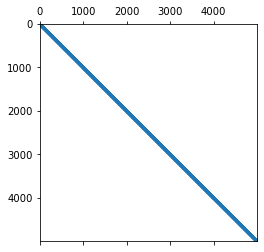

In [78]:
# !pip install primme
import primme
import scipy.sparse.linalg as spsplin
import scipy.sparse as spsp

# A = spsp.rand(10000, 10000, density=1e-5, random_state=10, format="csr")  * 10
# A = A + A.T

n = 5000
ex = -np.ones(n)
A = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr')
# e = sp.sparse.eye(n)
# A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)

print("Number of nnz", A.nnz)
plt.spy(A, markersize=1)
k = 10
print(spsplin.eigsh(A, k=k)[0][::-1])
print(primme.eigsh(A, k=k)[0])
print(spsplin.lobpcg(A, np.random.randn(A.shape[0], k), maxiter=700)[0])

%timeit spsplin.eigsh(A, k=k)
%timeit primme.eigsh(A, k=k)
%timeit spsplin.lobpcg(A, np.random.randn(A.shape[0], k), maxiter=700)

## Take-home message about large scale partial eigenvalue problem

- Arnoldi and Lanczos methods. Shift-and-invert strategy is very expensive since inversion must be done very accurately.
- Preconditioned iterative methods (PINVIT, LOBPCG, JD). Good for inexact inversions. 
- There is a software for using them
- There is a lot of technical issues hidden (restarts, spurious eigenvalues, stability)

## Intro to streaming algorithms

- Streaming algorithms process data samples one-by-one and do not store entire dataset
- Sketching approach
- Typical applications are solving linear systems, PCA, graph sparsification 

### Oja's method

- Embed the stream data in the orthonormal low dimensional subspace linearly such that the variance is maximized
- Optimization problem

$$ \max_{W \in \mathbb{R}^{n \times k}, W^{\top}W = I} \mathrm{trace}(W^{\top}\hat{\Sigma}W), $$

where $\hat{\Sigma}$ is sampled covariance matrix.

- The solution is the $k$ leading eigenvector
- But the samples are coming one-by-one, so you can not store them all in memory
- Stochastic gradient method helps in this case
- The result Oja's method
    - Update: $W_{k+1} = W_k + \eta_k x_t x_t^{\top}W_k$, where $\eta_k$ is a learning rate
    - Project: compute $Q$ from QR decompisition of $W_{k+1}$ and replace $W_{k+1} = Q$

## Sketching

- Replace matrix $A$ with another matrix $SA$, where matrix $SA$ has significantly smaller number of rows but preserves some important properties of matrix $A$
- Possible choices:
    - random projection
    - random row selection
- Example: linear least squares problem $\|Ax - b\|_2^2 \to \min_x$ transforms to $\| (SA)y - Sb \|_2^2 \to \min_y$ and we expect that $x \approx y$
- [Blendenpick](https://pdos.csail.mit.edu/~petar/papers/blendenpik-v1.pdf) solver is based on that idea and outperforms LAPACK routine 
- More details see in [Sketching as a Tool for Numerical Linear Algebra](https://researcher.watson.ibm.com/researcher/files/us-dpwoodru/wNow3.pdf) by D. Woodruff

## Next lecture


- Final lecture: we will talk about multilinear algebra and tensors

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()